# Factor Driven Signals

20190109, Michael

This notebook demonstrates basic factor analysis with a focus on signal creation. Previous projects, conducted by Duy, Raza and Jarek, have selected factors (mostly fundamental) that show strong predictive power measured by relationship between factor values and stock future returns. All factor data used in this notebook have the same 2D time-series format and universe is Russell 3000.

The term "factor" has been used liberally throughout the industry and may refer to style, strategy, industry, country, etc. This notebook mostly focus on company-specific fundamental factors. Entry signal is cross-sectionally rank of latest factor values and then long top x% of pool and short the bottom x%. As a result, portfolio is hedged and market netural. Return earned by such a hedged portfolio is also known as factor's risk premium. Exit signal is fixed holding days, such as 5 days. Will a factor with consistent past outputperformance persist in the future depends on what forces have driven the factor historically and whether those forces will continue to persist.

## Previously selected factors

**1) Factors used in ML2 project:** 
    
    R3K_ALPHA3D_RATIO_STD_W500
    R3K_ANR_CHANGE_250_FF_250
    R3K_DAYS_FROM_LAST_ANN
    R3K_SI_EQ_RATIO_FF
    R3K_VOL_RATIO_20

    data dir:
        
        \\farmnas\farm\_JIRA\DATA\DATA-496\20181101\ML2_Dump\

    factor description:
  
        \\farmnas\farm\_JIRA\DATA\DATA-496\20181101\ML2_Dump\Factors.docx
  
    * ML2 is a 5-factor decision tree model with gradient boosting. 
    ** Consult Duy for details.
        
**2) Factors selected in fundamental factors project:**
    
    C_TOTDEBTtoMCAP-E_QoQtoMCAP_EA_MR
    C_TOTLIABtoMCAP-E_VaL_EA_NA
    Q_1Y_EARNINGS_G_toMCAP-E_VaL_EA_NA
    Q_1Y_EARNINGS_G_toMCAP-E_YoYtoMCAP_EA_MR
    Q_1Y_EARNINGS_G_toMCAP-E_YtoMCAPoYtoMCAP_EA_MR
    Q_1Y_EARNINGStoMCAP-E_VaL_EA_NA
    Q_1Y_EARNINGStoMCAP-E_YoYtoMCAP_EA_MR
    Q_1Y_EARNINGStoMCAP-E_YtoMCAPoYtoMCAP_EA_MR
    Q_1Y_EBITDAtoMCAP-E_YoYtoMCAP_EA_MR
    Q_1Y_FCFtoMCAP-E_VaL_EA_NA
    Q_1Y_NETINCtoMCAP-E_VaL_EA_NA
    Q_1Y_NETINCtoMCAP-E_YoYtoMCAP_EA_MR
    Q_1Y_NETINCtoMCAP-E_YtoMCAPoYtoMCAP_EA_MR
    Q_1Y_PRETAXINCtoMCAP-E_VaL_EA_NA
    Q_1Y_PRETAXINCtoMCAP-E_YoYtoMCAP_EA_MR
    Q_1Y_PRETAXINCtoMCAP-E_YtoMCAPoYtoMCAP_EA_MR
    Q_1Y_SALEStoMCAP-E_VaL_EA_NA
    Q_1Y_SALEStoMCAP-E_YoYtoMCAP_EA_MR
    T12M_1Y_EBITDAtoMCAP-E_VaL_EA_NA
    T12M_1Y_FCFtoMCAP-E_VaL_EA_NA
    T12M_1Y_FCFtoMCAP-E_YoYtoMCAP_EA_MR
    T12M_1Y_SALEStoMCAP-E_VaL_EA_NA
    T12M_FCFtoTOTLIAB-E_QoQtoTOTLIAB_EA_MR
    T12M_ROA-E_QoQ_EA_MR
    T12M_ROE-E_QoQ_EA_MR
    
    data dir:
        
        \\farmnas\FARM\_FundamentalData\Factor\RUSSELL3000_CONSOLIDATED\FactorSheetFormulasDump\20180323\eaValue\
     
    factor description:
        
        \\farmnas\FARM\_FundamentalData\Factor\RUSSELL3000_CONSOLIDATED\FactorSheetFormulasDump\20180323\FactorSheet\Fundamental Factors Defined Sep20171222_V6 - Copy.xlsm
    
    * Factors have been selected based on various performance measurements. the above directory contains unselected factors data as well. 
    ** Consult Raza for details.
    
**3) Factor from Alpha Decomposition project:**
    
    HPcycle3
    
    data dir:
        
        \\phra-nas\NAS\DataShare\FOLDERS FROM PREVIOUS STAFFS\Jarek\AlphaSignal\AlphaDecomposition\HPcycle3.csv
        

In [8]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

dir_pool_dump=r'\\farmnas\FARM\_PoolDump\RUSSELL3000_CONSOLIDATED\LATEST\\'

In [9]:
class SignalStrengthAnalysis:
    
    """test EW signal strength (pool rank) by constructing market neutral portfolio over fixed holding length.

    Args:
    
        df_signal (pandas df): dataframe, fasttab (index=date str "yyyy-mm-dd", columns=ticker str)
        df_future_return (pandas df): return dataframe, fasttab
        df_pool_indicator (pandas df): pool indicator dataframe, fasttab
        signal_type (str: reversion, momentum): default to 'momentum'
        signal_freq (str: daily, event): default to 'daily'
        ths (list of float): pool rank THs for entry, default to [0, 0.25, 0.5, 0.75]
    
    Attributes:
        
        df_signal_rank: ranked signals df
        
    """
    
    def __init__(self, 
                 df_signal, 
                 df_future_return, 
                 df_pool_indicator,
                 signal_type='momentum', 
                 signal_freq='daily',
                 ths=[0, 0.25, 0.5, 0.75]):
        
        self.df_signal=df_signal
        self.df_future_return=df_future_return
        self.df_pool_indicator=df_pool_indicator
        self.signal_type=signal_type
        self.signal_freq=signal_freq      
        self.ths=ths
        
        self.dict_signal_type={'reversion':-1,
                               'momentum':1,}
        #check signal type
        assert (self.signal_type in self.dict_signal_type.keys())
        
        df_signal_ffill=(self.df_signal.fillna(method='ffill'))[self.df_pool_indicator==1]
        self.df_signal_rank=(df_signal_ffill.rank(axis=1, pct=True, ascending=True)-0.5)*2* \
        self.dict_signal_type[self.signal_type]
        
        if self.signal_freq=='event':
            
            self.df_signal_rank=self.df_signal_rank[self.df_signal.notnull()==True]
            
        return    
    
    def dump_signal(self, out_path):
        
        """dump ranked signal to csv
        
        Args:
            out_path (obj): full path

        """
        
        self.df_signal_rank.to_csv(out_path)
        
        return
        
    def plot_return(self, title_str=''):
        
        """plot cumulative return and daily trades count based on signal th and fixed HD

        Args:
            title_str (str): graph title 

        Returns:
            ax_ret: return plot
            ax_count: trade count plot            
            df_summary (pandas df): cumulative return series
            
        """
            
        for th in self.ths:

            df_signal=self.df_signal_rank[self.df_signal_rank.abs()>=th].apply(np.sign) # EW signal
            df_count=pd.DataFrame(df_signal.abs().sum(axis=1))
            df_count.columns=['th=%s'%th]            
            df_ret=pd.DataFrame((self.df_future_return*df_signal).mean(axis=1))
            df_ret.columns=['th=%s'%th]
            
            if th==self.ths[0]:
                
                df_ret_all=df_ret
                df_count_all=df_count
                
            else:
            
                df_ret_all=df_ret_all.join(df_ret,how='outer')
                df_count_all=df_count_all.join(df_count,how='outer')
        
        #return plot        
        df_ret_all=df_ret_all.dropna(how='all', axis=0) 
        df_ret_all.index=pd.to_datetime(df_ret_all.index)
        
        ax_ret=df_ret_all.fillna(0).cumsum().plot() 
        _=plt.title(title_str, fontsize = 'large')
        _=plt.ylabel('cum return %') 
        _=plt.show() 

        #trades count plot        
        df_count_all=df_count_all.dropna(how='all', axis=0) 
        df_count_all.index=pd.to_datetime(df_count_all.index)
        
        ax_count=df_count_all.plot() 
        _=plt.title(title_str, fontsize = 'large')
        _=plt.ylabel('trade count') 
        _=plt.show() 
        
        return ax_ret, ax_count, df_ret_all

## Construct factor path dictionary

In [26]:
# ml2 project factors
dir_ml2_factor=r'\\farmnas\farm\_JIRA\DATA\DATA-496\20181101\ML2_Dump\\'
list_ml2_factor=['R3K_ALPHA3D_RATIO_STD_W500','R3K_ANR_CHANGE_250_FF_250','R3K_SI_EQ_RATIO_FF', \
                  'R3K_VOL_RATIO_20'] #R3K_DAYS_FROM_LAST_ANN is removed, as it is not a stand alone factor
list_ml2_factor_path=[dir_ml2_factor+x+'.csv' for x in list_ml2_factor]
dict_ml2_factor_path=dict(zip(list_ml2_factor,list_ml2_factor_path))

# fundamental project factors
dir_funda_factor=r'\\farmnas\FARM\_FundamentalData\Factor\RUSSELL3000_CONSOLIDATED\FactorSheetFormulasDump\20180323\eaValue\\'
list_funda_factor=[ 'R3K_C_TOTDEBTtoMCAP-E_QoQtoMCAP_EA_MR',
                    'R3K_C_TOTLIABtoMCAP-E_VaL_EA_NA',
                    'R3K_Q_1Y_EARNINGS_G_toMCAP-E_VaL_EA_NA',
                    'R3K_Q_1Y_EARNINGS_G_toMCAP-E_YoYtoMCAP_EA_MR',
                    'R3K_Q_1Y_EARNINGS_G_toMCAP-E_YtoMCAPoYtoMCAP_EA_MR',
                    'R3K_Q_1Y_EARNINGStoMCAP-E_VaL_EA_NA',
                    'R3K_Q_1Y_EARNINGStoMCAP-E_YoYtoMCAP_EA_MR',
                    'R3K_Q_1Y_EARNINGStoMCAP-E_YtoMCAPoYtoMCAP_EA_MR',
                    'R3K_Q_1Y_EBITDAtoMCAP-E_YoYtoMCAP_EA_MR',
                    'R3K_Q_1Y_FCFtoMCAP-E_VaL_EA_NA',
                    'R3K_Q_1Y_NETINCtoMCAP-E_VaL_EA_NA',
                    'R3K_Q_1Y_NETINCtoMCAP-E_YoYtoMCAP_EA_MR',
                    'R3K_Q_1Y_NETINCtoMCAP-E_YtoMCAPoYtoMCAP_EA_MR',
                    'R3K_Q_1Y_PRETAXINCtoMCAP-E_VaL_EA_NA',
                    'R3K_Q_1Y_PRETAXINCtoMCAP-E_YoYtoMCAP_EA_MR',
                    'R3K_Q_1Y_PRETAXINCtoMCAP-E_YtoMCAPoYtoMCAP_EA_MR',
                    'R3K_Q_1Y_SALEStoMCAP-E_VaL_EA_NA',
                    'R3K_Q_1Y_SALEStoMCAP-E_YoYtoMCAP_EA_MR',
                    'R3K_T12M_1Y_EBITDAtoMCAP-E_VaL_EA_NA',
                    'R3K_T12M_1Y_FCFtoMCAP-E_VaL_EA_NA',
                    'R3K_T12M_1Y_FCFtoMCAP-E_YoYtoMCAP_EA_MR',
                    'R3K_T12M_1Y_SALEStoMCAP-E_VaL_EA_NA',
                    'R3K_T12M_FCFtoTOTLIAB-E_QoQtoTOTLIAB_EA_MR',
                    'R3K_T12M_ROA-E_QoQ_EA_MR',
                    'R3K_T12M_ROE-E_QoQ_EA_MR',]

list_funda_factor_path=[dir_funda_factor+x+'.csv' for x in list_funda_factor]
dict_funda_factor_path=dict(zip(list_funda_factor,list_funda_factor_path))

# alpha decompo factor

dict_hpcycle_path={'HPcycle3':r'\\phra-nas\NAS\DataShare\FOLDERS FROM PREVIOUS STAFFS\Jarek\AlphaSignal\AlphaDecomposition\HPcycle3.csv'}

# merge dictionaries

dict_factor_path={}
dict_factor_path.update(dict_ml2_factor_path)
dict_factor_path.update(dict_funda_factor_path)
dict_factor_path.update(dict_hpcycle_path)

## Signal type dictionary

* reversion
* momentum

In [24]:
dict_factor_signal_type=dict(zip(dict_factor_path.keys(),len(dict_factor_path)*['momentum'])) #default momentum

#following factors are reversion factors from previous work
dict_factor_signal_type['R3K_ALPHA3D_RATIO_STD_W500']='reversion'
dict_factor_signal_type['R3K_SI_EQ_RATIO_FF']='reversion'
dict_factor_signal_type['R3K_C_TOTDEBTtoMCAP-E_QoQtoMCAP_EA_MR']='reversion'

## Signal frequency dictionary

Most fundamental factors are not updated daily and hence signals can be traded when factor values get updated (**event**) or forward-filled to trade **daily**.
    
* daily
* event

In [16]:
dict_factor_signal_freq=dict(zip(dict_factor_path.keys(),len(dict_factor_path)*['event'])) #default event

#following factors are better traded daily based on previous work
for key in list_ml2_factor:

    dict_factor_signal_freq[key]='daily'
    
dict_factor_signal_freq['HPcycle3']='daily'

## Signal strength test

### Select HD and target future return

In [13]:
# read data, set HD
HD=5
start_date='2010-01-01'

df_pool_indicator=pd.read_csv(dir_pool_dump+'_poolIndicatorF.csv', index_col=0).loc[start_date:]
#signal is at close, trades enter at next open, shifting target return by -1
df_future_return=pd.read_csv(dir_pool_dump+'FWDReturns\FWD_Ret_O2O_W%s.csv'%HD, index_col=0).shift(-1).loc[start_date:] 


### Select factor to test

In [14]:
factor_select='R3K_SI_EQ_RATIO_FF'

df_factor=pd.read_csv(dict_factor_path[factor_select], index_col=0).loc[start_date:]

In [15]:
singal_strength=SignalStrengthAnalysis(  df_factor, 
                                         df_future_return, 
                                         df_pool_indicator,
                                         signal_type=dict_factor_signal_type[factor_select], 
                                         signal_freq=dict_factor_signal_freq[factor_select],
                                         ths=[0, 0.25, 0.5, 0.75])

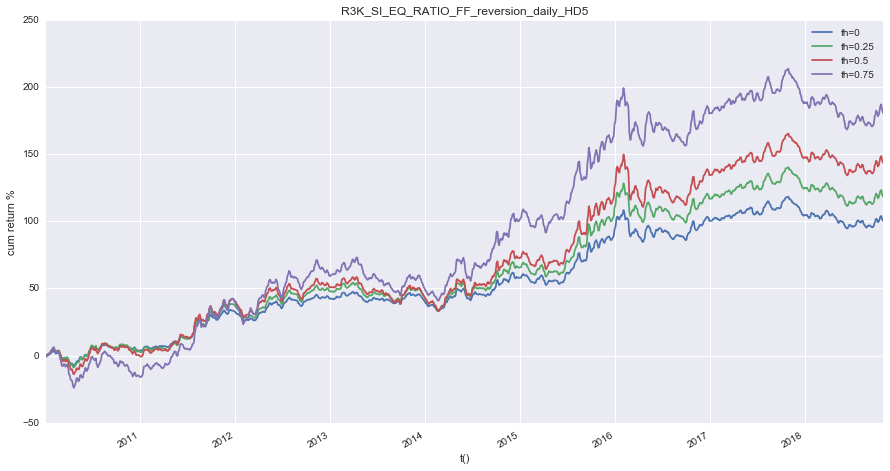

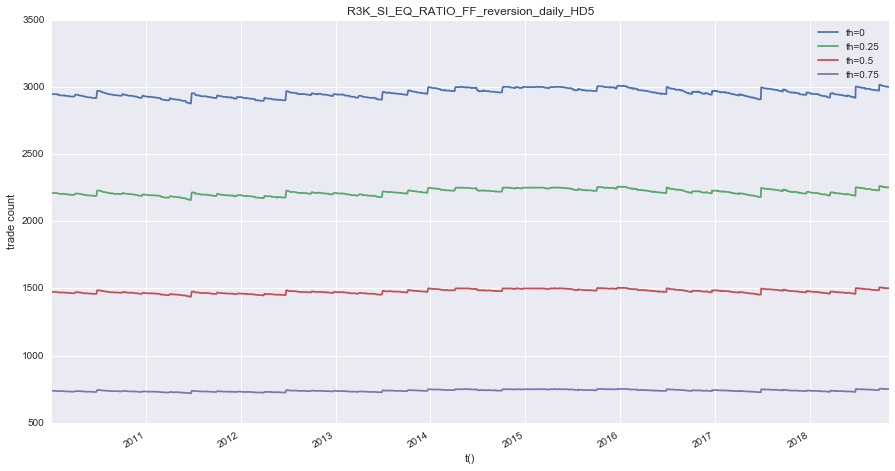

In [23]:
_title='%s_%s_%s_HD%s'%(factor_select,dict_factor_signal_type[factor_select],dict_factor_signal_freq[factor_select],HD)
plt.rcParams["figure.figsize"] = [15,8]
ax_ret, ax_count, df_summary=singal_strength.plot_return(_title)

## Create signal files for backtest

In [27]:
for factor_select in [_factor for _factor in dict_factor_path.keys() if 'HPcycle3' in _factor]:
    
    print factor_select
    
    try:
        
        df_factor=pd.read_csv(dict_factor_path[factor_select], index_col=0).loc[start_date:]

        singal_strength=SignalStrengthAnalysis(  df_factor, 
                                                 df_future_return, 
                                                 df_pool_indicator,
                                                 signal_type=dict_factor_signal_type[factor_select], 
                                                 signal_freq=dict_factor_signal_freq[factor_select],
                                                 ths=[0, 0.25, 0.5, 0.75])

        _name='%s_%s_%s_poolrank'%(factor_select,dict_factor_signal_type[factor_select],dict_factor_signal_freq[factor_select])

        singal_strength.dump_signal(r'\\farmnas\FARM\Research\mchen\reports\factor_analysis\signal\%s.csv'%_name)
        
    except:
        
        print 'error processing data'
        
        continue

HPcycle3
